In [0]:
import tensorflow as tf 
import pandas as pd 
import numpy as np
import csv
#from google.colab import files
#uploaded = files.upload()

#load the data
file = open("drugsComTrain_raw.tsv","r").readlines()


In [0]:
for i in range(len(file)):
    file[i] = file[i].split('\t')

df = pd.DataFrame(data = file[1:], columns = file[0])
df.columns

Index([u'', u'drugName', u'condition', u'review', u'rating', u'date',
       u'usefulCount\r\n'],
      dtype='object')

In [ ]:
reviews = list(df['review'])
numTweets = len(reviews)
print(numTweets)
#print(type(reviews[0]),type(reviews[numTweets-1]))

#counting the total number of words
numWords = []
count = 0
for i in range(numTweets):
    if(reviews[i]):
        line = reviews[i].split()
        print(line)
        counter = int(len(line))
        numWords.append(counter)

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

maxSeqLength = max(numWords) #longest review in the existing data

In [0]:
#print(numWords)
maxSeqLength = max(numWords)
print(numWords.index(maxSeqLength))
print(maxSeqLength)

157143
1107


In [0]:
#uploaded = files.upload()
wordVectors = np.load('wordVectors.npy')

In [0]:
#load the numbered word vectors
#uploaded = files.upload()
wordsList = np.load('wordsList.npy')
wordsList = [word.decode('UTF-8') for word in wordsList]


In [0]:
#load the numbered word vectors
#uploaded = files.upload()
wordsList = np.load('wordsList.npy')
wordsList = [word.decode('UTF-8') for word in wordsList]
#uploaded = files.upload()
wordVectors = np.load('wordVectors.npy')

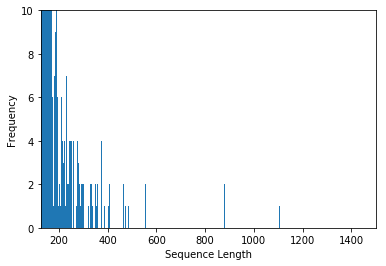

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 500)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([125, 1500, 0, 10])
plt.show()

In [0]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def decontracted(phrase):
    # specific
    #phrase = re.sub(r"won\'t", "will not", phrase)
    #phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    string = string.lower().replace("\n", "")
    string = decontracted(string)
    return re.sub(strip_special_chars, "", string.lower())

In [ ]:
#defining an ids matrix for the word vectors from the list
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
reviewCounter = 0
for i in range(10):
    index = 0
    if reviews[i]:
        cleanedLine = cleanSentences(reviews[i])
        #print(cleanedLine)
        line = cleanedLine.split(' ')
        for word in line:
            try:
                ids[reviewCounter][index] = wordsList.index(word)
            except ValueError:
                ids[reviewCounter][index] = 399999 #Vector for unkown words
            index = index + 1
        if index >= maxSeqLength:
            break
        reviewCounter = reviewCounter + 1

np.save('idsMatrix_trained',ids)

In [0]:
idMat = np.load('idsMatrix_model.npy')
len(idMat) #179281 #44820(1/4th)

179281

In [0]:
np.mean(idMat) #1760.34436180006
print(idMat.shape)
import collections
list_of_outlier_words = {}
for i in range(numFiles):
    no_of_unwanted_words = dict(collections.Counter(idMat[i]))
    #print(no_of_unwanted_words)
    list_of_outlier_words[i] = no_of_unwanted_words


(179281, 1107)


**Splitting Data Batch-wise**

In [0]:
from random import randint   #1/4th of the training set

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,82462) #1,20616
            labels.append([1,0])
        else:
            num = randint(96805,179274) #24201, 44819
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(82462, 96805) #20616, 24201 
        if (num <= 89633):          #22408
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels


**RNN Model**

In [0]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 100000

In [0]:
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [0]:
numDimensions = 300
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [0]:

lstmCell = tf.nn.rnn_cell.LSTMCell(lstmUnits)
lstmCell = tf.nn.rnn_cell.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [0]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [0]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [0]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [0]:
sess = tf.InteractiveSession()

import datetime


tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

**Training**

In [0]:

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
  #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
    #Write summary to Tensorboard
    if (i % 50 == 0): #50
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        #print("Summary added %d"%(i))
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 1000 == 0 and i != 0): #10000
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()


Summary added 0
Summary added 50
Summary added 100
Summary added 150
Summary added 200
Summary added 250
Summary added 300
Summary added 350
Summary added 400
Summary added 450
Summary added 500
Summary added 550
Summary added 600
Summary added 650
Summary added 700
Summary added 750
Summary added 800
Summary added 850
Summary added 900
Summary added 950
Summary added 1000
saved to models/pretrained_lstm.ckpt-1000
Summary added 1050
Summary added 1100
Summary added 1150
Summary added 1200
Summary added 1250
Summary added 1300
Summary added 1350
Summary added 1400
Summary added 1450
Summary added 1500
Summary added 1550
Summary added 1600
Summary added 1650
Summary added 1700
Summary added 1750
Summary added 1800
Summary added 1850
Summary added 1900
Summary added 1950
Summary added 2000
saved to models/pretrained_lstm.ckpt-2000
Summary added 2050
Summary added 2100
Summary added 2150
Summary added 2200
Summary added 2250
Summary added 2300
Summary added 2350
Summary added 2400
Summary 

KeyboardInterrupt: 

In [0]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-15000


**Accuracy**

In [ ]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

**Testing**

In [0]:
test_file = open("drugsComTest_raw.tsv","r").readlines()

In [0]:
for i in range(len(test_file)):
    test_file[i] = test_file[i].split('\t')

test_df = pd.DataFrame(data = test_file[1:], columns = test_file[0])
test_df.columns

Index([u'', u'drugName', u'condition', u'review', u'rating', u'date',
       u'usefulCount\r\n'],
      dtype='object')

In [ ]:
test_reviews = list(test_df['review'])
test_numTweets = len(test_reviews)
print(test_numTweets)
print(type(test_reviews[0]),type(test_reviews[test_numTweets-1]))

#counting the total number of words
test_numWords = []
t_count = 0
for i in range(test_numTweets):
    if(test_reviews[i]):
        line = test_reviews[i].split()
        #print(line)
        counter = int(len(line))
        test_numWords.append(counter)

test_numFiles = len(test_numWords)
print('The total number of files is', test_numFiles)
print('The total number of words in the files is', sum(test_numWords))
print('The average number of words in the files is', sum(test_numWords)/len(test_numWords))

test_maxSeqLength = max(test_numWords)

In [0]:
test_maxSeqLength = max(test_numWords)
#print(test_numWords.index(test_maxSeqLength))
#print(test_maxSeqLength)

1028
511


In [0]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("\n", "")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

In [0]:
rand_index = randint(0, len(test_reviews)-1)
print(rand_index)
inputText = test_reviews[rand_index]
inputMatrix = getSentenceMatrix(inputText)

54732


In [ ]:
print(inputText)
print(inputMatrix)

In [ ]:
predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]
# predictedSentiment[0] represents output score for positive sentiment
# predictedSentiment[1] represents output score for negative sentiment

if (predictedSentiment[0] > predictedSentiment[1]):
    print "Positive Sentiment"
else:
    print "Negative Sentiment"